In [1]:
#! micromamba create --name pytorch -c conda-forge -c defaults -c pytorch pytorch-gpu matplotlib h5py ipykernel

In [1]:
import os
# os.chdir('/disk/scratch2/nkudryas/BAND-torch/')
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

# import matplotlib.pyplot as plt
import numpy as np
import h5py
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from lfads_torch.benchmark.biRNN_decoder import Decoder, r2_score

/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class multi_Decoder(nn.Module):
    '''
    1. Dropout some spikes
    2. Run RNN (with batchnorm)
    3. 2 layer MLP
    '''
    def __init__(self, 
                input_size,
                pre_rnn_size,
                rnn_size, 
                hidden_size, 
                output_size, 
                seq_len, 
                num_layers,
                rnn_dropout = 0.1,
                spike_dropout_rate = 0.4,
                dropout = 0.4,):
        super(multi_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.input_dropout = nn.Dropout(p=spike_dropout_rate)
        self.readin = {key: nn.Linear(input_size[key], pre_rnn_size) for key in input_size.keys()}
        self.rnn = nn.LSTM(pre_rnn_size,
                          rnn_size, 
                          num_layers=num_layers,
                          dropout=rnn_dropout,
                          bidirectional=True,
                          batch_first=True,)
        self.batchnorm = nn.BatchNorm1d(seq_len, track_running_stats=False)
        self.fc = nn.Linear(2*rnn_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: dict[torch.Tensor]):

        # Set initial hidden and cell states
        # h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda()
        # c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda()
        
        # Determine which sessions are in the batch
        sessions = sorted(x.keys())
        # Keep track of batch sizes so we can split back up
        batch_sizes = [len(x[s]) for s in sessions]
        # Pass the data through the readin networks
        encod_data = torch.cat([self.readin[s](self.input_dropout(x[s])) for s in sessions])
        
        # Forward propagate
        out, _ = self.rnn(encod_data) #, (h0,c0))
        out = nn.ReLU()(out)
        out = self.batchnorm(out)
  
        out = self.fc(out)
        out = nn.ReLU()(out)
        out = self.batchnorm(out)
        factors = self.dropout(out)

        factors = torch.split(factors, batch_sizes)
        out = {s: self.fc2(out) for s,out in zip(sessions,factors)}

        return out

In [3]:
area = 'all'
short_dataset_names = [#'Chewie_CO_FF_2016-09-15',
                       # 'Chewie_CO_FF_2016-09-21',
                       #     'Chewie_CO_FF_2016-10-05',
                       #     'Chewie_CO_FF_2016-10-07',
                        'Mihili_CO_FF_2014-02-03',
                       'Mihili_CO_FF_2014-02-17',
                       'Mihili_CO_FF_2014-02-18',
                       'Mihili_CO_FF_2014-03-07',]

train_data_raw, valid_data_raw = {}, {}
train_behavior, valid_behavior = {}, {}
train_epoch, valid_epoch = {}, {}
train_inds, valid_inds = {}, {}
train_target_direction, valid_target_direction = {}, {}

T = 85
for short_dataset_name in short_dataset_names:
    dataset_name = f'{short_dataset_name}_session_vel_{area}_spikes_go'
    loadpath = f'/disk/scratch2/nkudryas/BAND-torch/datasets/{dataset_name}.h5'

    h5file = h5py.File(loadpath, 'r')

    train_data_raw[short_dataset_name]=h5file['train_recon_data'][:,:T].astype(np.float32)
    valid_data_raw[short_dataset_name]=h5file['valid_recon_data'][:,:T].astype(np.float32)
    train_behavior[short_dataset_name]=h5file['train_behavior'][:,:T].astype(np.float32)
    valid_behavior[short_dataset_name]=h5file['valid_behavior'][:,:T].astype(np.float32)
    train_epoch[short_dataset_name]=h5file['train_epoch'][()].astype(np.float32)
    valid_epoch[short_dataset_name]=h5file['valid_epoch'][()].astype(np.float32)
    train_inds[short_dataset_name]=h5file['train_inds'][()].astype(np.float32)
    valid_inds[short_dataset_name]=h5file['valid_inds'][()].astype(np.float32)

    train_target_direction[short_dataset_name]=h5file['train_target_direction'][()].astype(np.float32)
    valid_target_direction[short_dataset_name]=h5file['valid_target_direction'][()].astype(np.float32)
    # print(h5file.keys())
    h5file.close()

In [4]:
for k,v in train_data_raw.items():
    print(v.shape)

(482, 85, 114)
(714, 85, 148)
(728, 85, 159)
(622, 85, 92)


In [5]:
train_data = train_data_raw
valid_data = valid_data_raw
# train an RNN decoder to predict behavior from neural activity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# number of neurons, number of behavior dimensions
N, M = {k: v.shape[-1] for k,v in train_data.items()}, train_behavior[list(train_behavior.keys())[0]].shape[-1] 

assert M == 2, 'only 2D behavior is expected'
rnn = multi_Decoder(input_size=N, 
              pre_rnn_size=128,
              rnn_size=128,
              hidden_size=128, 
              output_size=M, 
              seq_len=T, 
              num_layers=3,
              rnn_dropout = .5,
              spike_dropout_rate = 0.2,
              dropout = 0.3).to(device)

rnn.readin = nn.ModuleDict({k: v.to(device) for k,v in rnn.readin.items()})


# Loss and optimizer
loss = nn.MSELoss()
# higher weight decay for RNN
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.95, verbose=True)

# Convert numpy arrays to torch tensors
inputs = {k: torch.from_numpy(v).to(device) for k,v in train_data.items()}
behaviors = {k: torch.from_numpy(v).to(device) for k,v in train_behavior.items()}
test_inputs = {k: torch.from_numpy(v).to(device) for k,v in valid_data.items()}
test_behaviors = {k: torch.from_numpy(v).to(device) for k,v in valid_behavior.items()}

# Train the model
dataset_name = 'Chewie'
num_epochs = 2000
batch_size = 100
for epoch in range(num_epochs):

    batch = {k: torch.from_numpy(np.random.choice(list(range(v.shape[0])), batch_size)).to(device) for k,v in inputs.items()}

    # print(batch)

    # Forward pass
    outputs = rnn({k: inputs[k][batch[k]] for k in inputs.keys()})
    sess_cost = [loss(outputs[k], behaviors[k][batch[k]]) for k in inputs.keys()]
    
    cost = torch.mean(torch.stack(sess_cost))

    # Backward and optimize
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    scheduler.step(cost)

    # print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.4f}, Test Loss: {test_cost.item():.4f}')
    # print epoch and R2
    if (epoch+1) % 10 == 0:
        # predict on test
        rnn.eval()
        train_outputs = rnn({k: inputs[k][batch[k]] for k in inputs.keys()})
        train_sess_cost = [loss(outputs[k], behaviors[k][batch[k]]) for k in inputs.keys()]
        train_cost = torch.mean(torch.stack(train_sess_cost))
        test_outputs = rnn({k: test_inputs[k] for k in test_inputs.keys()})
        test_sess_cost = [loss(test_outputs[k], test_behaviors[k]) for k in test_inputs.keys()]
        test_cost = torch.mean(torch.stack(test_sess_cost))
        rnn.train()
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_cost.item():.4f}, Test Loss: {test_cost.item():.4f}, R2: ',{r2_score(test_behaviors[k], test_outputs[k]).item() for k in test_outputs.keys()})
        

cuda
Epoch [10/2000], Loss: 56.6029, Test Loss: 54.8162, R2:  {0.18257907032966614, 0.16971486806869507, 0.20758050680160522, 0.22194766998291016}
Epoch [20/2000], Loss: 49.9461, Test Loss: 49.5169, R2:  {0.2562575340270996, 0.2650856077671051, 0.29318785667419434, 0.2669898569583893}
Epoch [30/2000], Loss: 39.9967, Test Loss: 38.7306, R2:  {0.3937605321407318, 0.42684900760650635, 0.4520154595375061, 0.4419403672218323}
Epoch [40/2000], Loss: 31.5310, Test Loss: 30.8256, R2:  {0.505896270275116, 0.5501359105110168, 0.5779906511306763, 0.5525580644607544}
Epoch [50/2000], Loss: 25.2097, Test Loss: 23.7488, R2:  {0.6213607788085938, 0.6557801961898804, 0.67828369140625, 0.6486541032791138}
Epoch [60/2000], Loss: 19.4753, Test Loss: 19.8069, R2:  {0.6809148788452148, 0.7092581987380981, 0.7351690530776978, 0.7116094827651978}
Epoch [70/2000], Loss: 16.8865, Test Loss: 16.6416, R2:  {0.7292784452438354, 0.7523113489151001, 0.7860000133514404, 0.7545797824859619}
Epoch [80/2000], Loss: 15.

In [6]:
import os
os.chdir("../paper/")
from plot_helpers import get_random_trials2plot
os.chdir("../rnn_decoder/")

dir_index = {experiment: np.array([
        sorted(set(valid_target_direction[experiment])).index(i) for i in valid_target_direction[experiment]
    ]) for experiment in short_dataset_names}

np.random.seed(42)
trials2plot = {experiment: np.array([get_random_trials2plot(dir_index[experiment], valid_epoch[experiment], i) for i in range(3)]).sum(0) for experiment in short_dataset_names}


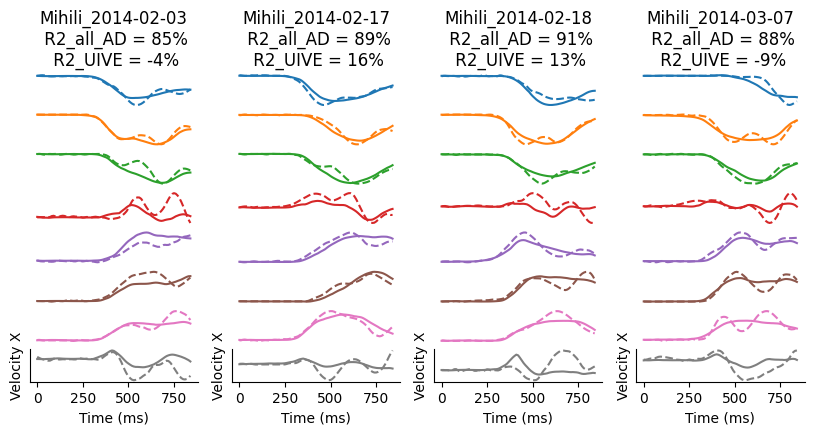

In [7]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)

    assert np.allclose(np.arange(8),np.unique(dir_index))
    avg_vel = [np.mean(vel[dir_index==d], axis=0) for d in range(8)]
    total_var = [np.sum((vel[dir_index==d] - avg_vel[d])**2) for d in range(8)]
    expl_var  = [np.sum((pred_vel[dir_index==d] - vel[dir_index==d])**2) for d in range(8)] 
    for d in range(8):
        if total_var[d] == 0:
            total_var[d] = np.nan
    R2_UIVE = np.nanmean([1 - expl_var[d] / total_var[d] for d in range(8)])

    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%\n R2_UIVE = {R2_UIVE*100:.0f}%')

fig, axes = plt.subplots(8,4,figsize=(4*2.5, 8*.5))


component = 0

area = 'all'
for i, experiment in enumerate(short_dataset_names):

    # epoch_mask, epoch_name = (epoch[experiment]==0), 'BL'
    epoch_mask, epoch_name = (valid_epoch[experiment]==1), 'AD'
    # epoch_mask, epoch_name = (epoch[experiment]==2), 'WO'

    title = experiment.split('_CO_FF')
    title = title[0] + title[1]

    plot_beh_pred(valid_behavior[experiment][epoch_mask], 
                test_outputs[experiment].detach().cpu().numpy()[epoch_mask], 
                dir_index[experiment][epoch_mask], 
                trials2plot[experiment][epoch_mask], 
                axes[:,i], 
                area,
                epoch_name,
                component=1, 
                title=title)

# fig.savefig("figs/Figure4")

1. Implement R_UIVE in Fig4_decoding
2. Re-run single session decoders with no dropout -- does it change R_UIVE more than R2?
3. If so, run stats and neuron selection on single session decoders with no dropout

In [72]:
np.mean([34, 44, 38, 26]), np.std([34, 44, 38, 26]), np.mean([76,72,81,70]), np.std([76,72,81,70])

(35.5, 6.5383484153110105, 74.75, 4.205650960315181)

# Select optimal dropout

0it [00:00, ?it/s]

6it [07:47, 77.86s/it]


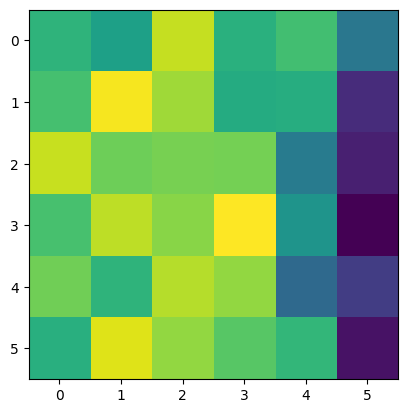

In [64]:
train_data = train_data_raw
valid_data = valid_data_raw
# train an RNN decoder to predict behavior from neural activity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
T = train_data.shape[1] # number of time bins

g = [.1,.2,.3,.4,.5,.6]
r2 = np.zeros((len(g),len(g)))
for i,dropout in tqdm(enumerate(g)):
    for j,spike_dropout_rate in enumerate(g):
        assert M == 2, 'only 2D behavior is expected'
        rnn = Decoder(input_size=N, 
                    rnn_size=128,
                    hidden_size=128, 
                    output_size=M, 
                    seq_len=T, 
                    num_layers=1,
                    spike_dropout_rate = spike_dropout_rate,
                    dropout = dropout).to(device)


        # Loss and optimizer
        loss = nn.MSELoss()
        # higher weight decay for RNN
        optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

        #scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

        # Convert numpy arrays to torch tensors
        inputs = torch.from_numpy(train_data).to(device)
        behaviors = torch.from_numpy(train_behavior).to(device)
        test_inputs = torch.from_numpy(valid_data).to(device)
        test_behaviors = torch.from_numpy(valid_behavior).to(device)

        # Train the model
        dataset_name = 'Chewie'
        num_epochs = 1000
        batch_size = 100
        for epoch in range(num_epochs):

            batch_indices = list(range(inputs.shape[0]))
            batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

            # print(batch)

            # Forward pass
            outputs = rnn(inputs[batch])
            cost = loss(outputs, behaviors[batch]) 

            # Backward and optimize
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            scheduler.step(cost)

        # predict on test
        rnn.eval()
        train_outputs = rnn(inputs)
        train_cost = loss(train_outputs, behaviors) 
        test_outputs = rnn(test_inputs)
        test_cost = loss(test_outputs, test_behaviors)
        r2[i,j] = r2_score(test_behaviors, test_outputs).item()
plt.imshow(r2)

In [66]:
np.where(r2==r2.max())

(array([3]), array([3]))

In [67]:
r2[3,3], r2[1,2]

(0.9249357581138611, 0.9205663800239563)

/tmp/ipykernel_78528/3138646154.py:81: RuntimeWarning: Mean of empty slice.
  avg_vel_per_epoch[mask] = vel[mask].mean(0)
/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


NameError: name 'test_outputs' is not defined

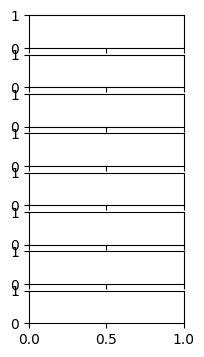

In [10]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%')

def get_trials2plot(pos, avg_pos, dir_index, epochs,epoch=1):
    '''
    Select the trials to plot based on the distance between 
    the average position and the position in single trials

    Parameters
    ----------
    pos : np.ndarray
        The position in single trials
    avg_pos : np.ndarray
        The average position
    dir_index : np.ndarray
        The direction index
    epochs : np.ndarray
        The epochs
    epoch : int, optional
        The epoch to consider, by default 1 (adaptation)

    Returns
    -------
    np.ndarray
        The trials to plot
    '''
    trials2plot = np.zeros_like(epochs)
    for d in np.unique(dir_index):
        mask = (epochs == epoch) & (dir_index == d)
        # print(mask)
        dist = ((pos - avg_pos) ** 2).sum(-1).sum(-1)
        dist[~mask] = -np.inf
        # print(dist)
        idx_max = np.argmax(dist)
        # print(idx_max)
        trials2plot[idx_max] = 1
    return trials2plot

fig, axes = plt.subplots(8, figsize=(2, 4), sharex=True)
dir_index = np.array([
        sorted(set(valid_target_direction)).index(i) for i in valid_target_direction
    ])

vel = valid_behavior
avg_vel = np.zeros_like(vel)
avg_vel_per_epoch = np.zeros_like(vel)
trial_coverage = np.zeros(vel.shape[0],dtype=bool)
for d in range(8):
    mask = d==dir_index
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==valid_epoch)
        avg_vel_per_epoch[mask] = vel[mask].mean(0)
        trial_coverage[mask] = 1
assert trial_coverage.all()

trials2plot = get_trials2plot(vel, avg_vel_per_epoch, dir_index, valid_epoch, epoch=1)

plot_beh_pred(valid_behavior[valid_epoch == 1], 
              test_outputs.detach().cpu().numpy()[valid_epoch == 1], 
              dir_index[valid_epoch == 1], 
              trials2plot[valid_epoch == 1], 
              axes, '', 'RNN', component=0, title=dataset_name)

# Try ablations

In [11]:
def train_and_get_r2(idxs,
    num_epochs = 1000,
    batch_size = 100):
    '''
    Takes in idxs to ablate
    '''

    train_data = train_data_raw.copy()
    train_data = np.delete(train_data,idxs,axis=-1)
    valid_data = valid_data_raw.copy()
    valid_data = np.delete(valid_data,idxs,axis=-1)

    # train an RNN decoder to predict behavior from neural activity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
    T = train_data.shape[1] # number of time bins
    assert M == 2, 'only 2D behavior is expected'
    rnn = Decoder(input_size=N, 
                rnn_size=128,
                hidden_size=128, 
                output_size=M, 
                seq_len=T, 
                num_layers=1,
                spike_dropout_rate = 0.2).to(device)


    # Loss and optimizer
    loss = nn.MSELoss()
    # higher weight decay for RNN
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(train_data).to(device)
    behaviors = torch.from_numpy(train_behavior).to(device)
    test_inputs = torch.from_numpy(valid_data).to(device)
    test_behaviors = torch.from_numpy(valid_behavior).to(device)

    # Train the model
    for epoch in range(num_epochs):

        batch_indices = list(range(inputs.shape[0]))
        batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

        # print(batch)

        # Forward pass
        outputs = rnn(inputs[batch])
        cost = loss(outputs, behaviors[batch]) 

        # Backward and optimize
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        scheduler.step(cost)

    # predict on test
    rnn.eval()
    test_outputs = rnn(test_inputs)

    return [r2_score(test_behaviors, test_outputs).item()] +\
           [r2_score(test_behaviors[valid_epoch==e], test_outputs[valid_epoch==e]).item() for e in [0,1,2]]


sel_idxs_all = {
    "Chewie_CO_FF_2016-09-15": [15, 30, 31, 45, 157],
    "Chewie_CO_FF_2016-09-21": [27],
    "Chewie_CO_FF_2016-10-05": [30,44],
    "Chewie_CO_FF_2016-10-07": [1, 27,	28, 35,	144, 157],
    "Mihili_CO_FF_2014-02-03": [13],  
    "Mihili_CO_FF_2014-02-17": [17],
    "Mihili_CO_FF_2014-02-18": [5, 15],
    "Mihili_CO_FF_2014-03-07": [2]
}
sel_idxs =sel_idxs_all[short_dataset_name]
n_ablate = len(sel_idxs)
no_ablation, top_score, r_score = [], [], []
for _ in range(10):

    no_ablation.append(train_and_get_r2([]))

    top_score.append(train_and_get_r2(sel_idxs))

    idxs = np.random.choice(range(train_data_raw.shape[-1]),n_ablate,replace=False)
    r_score.append(train_and_get_r2(idxs))

print(np.mean(no_ablation,axis=0),np.std(no_ablation,axis=0))
print(np.mean(top_score,axis=0),np.std(top_score,axis=0))
print(np.mean(r_score,axis=0),np.std(r_score,axis=0))

# save results as pkl

with open(f'../../results/abl_r2_{short_dataset_name}.pkl', 'wb') as f:
    pickle.dump([no_ablation, top_score, r_score], f)

            

[0.86737365 0.86708558 0.8513363  0.8740952 ] [0.00690472 0.00805738 0.00607364 0.00958647]
[0.86331561 0.8676025  0.84609481 0.86564127] [0.00480838 0.00586067 0.00489093 0.00874799]
[0.8661741  0.86561323 0.84670557 0.87601525] [0.00347662 0.0066214  0.00466006 0.00591416]


In [26]:
# with open(f'../../results/abl_r2_{short_dataset_name}.pkl', 'wb') as f:
#     pickle.dump([no_ablation, top_score, r_score], f)


In [10]:
# load
experiments = [
    "Chewie_CO_FF_2016-09-15",
    "Chewie_CO_FF_2016-09-21",
    "Chewie_CO_FF_2016-10-05",
    "Chewie_CO_FF_2016-10-07",
    "Mihili_CO_FF_2014-02-03",
    "Mihili_CO_FF_2014-02-17",
    "Mihili_CO_FF_2014-02-18",
    "Mihili_CO_FF_2014-03-07"
]

sel_idxs_all = {
    "Chewie_CO_FF_2016-09-15": [15, 30, 31, 45, 157],
    "Chewie_CO_FF_2016-09-21": [27],
    "Chewie_CO_FF_2016-10-05": [30,44],
    "Chewie_CO_FF_2016-10-07": [1, 27,	28, 35,	144, 157],
    "Mihili_CO_FF_2014-02-03": [13],  
    "Mihili_CO_FF_2014-02-17": [17],
    "Mihili_CO_FF_2014-02-18": [5, 15],
    "Mihili_CO_FF_2014-03-07": [2]
}


# combine in a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['dataset','no_ablation','top_neurons_abl','random_abl'])
for short_dataset_name in experiments:
    with open(f'../../results/abl_r2_{short_dataset_name}.pkl', 'rb') as f:
        no_ablation, top_score, r_score = pickle.load(f)
    df = pd.concat([df,pd.DataFrame({'dataset': [short_dataset_name]*len(no_ablation),
                                        'dataset_title': [short_dataset_name[-10:] + f'\nn={len(sel_idxs_all[short_dataset_name])}'] * len(no_ablation),
                                        'no_ablation': [100*a[2] for a in no_ablation],
                                        'random_abl': [100*a[2] for a in r_score],
                                        'top_neurons_abl': [100*a[2] for a in top_score],
                                        })])
                                    
df

/tmp/ipykernel_10331/2389107732.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame({'dataset': [short_dataset_name]*len(no_ablation),


,dataset,no_ablation,top_neurons_abl,random_abl,dataset_title
0,Chewie_CO_FF_2016-09-15,38.019470,38.195659,39.300967,2016-09-15\nn=5
1,Chewie_CO_FF_2016-09-15,41.525057,31.572806,40.299134,2016-09-15\nn=5
2,Chewie_CO_FF_2016-09-15,40.147156,39.315479,34.803399,2016-09-15\nn=5
3,Chewie_CO_FF_2016-09-15,38.054271,36.955446,36.980625,2016-09-15\nn=5
4,Chewie_CO_FF_2016-09-15,35.533883,36.317424,39.695247,2016-09-15\nn=5
...,...,...,...,...,...
5,Mihili_CO_FF_2014-03-07,-32.994358,-40.083896,-29.343065,2014-03-07\nn=1
6,Mihili_CO_FF_2014-03-07,-37.077750,-39.177153,-29.081327,2014-03-07\nn=1
7,Mihili_CO_FF_2014-03-07,-25.553850,-32.951441,-32.992057,2014-03-07\nn=1
8,Mihili_CO_FF_2014-03-07,-33.779837,-34.432991,-33.450047,2014-03-07\nn=1


/tmp/ipykernel_10331/2205221807.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


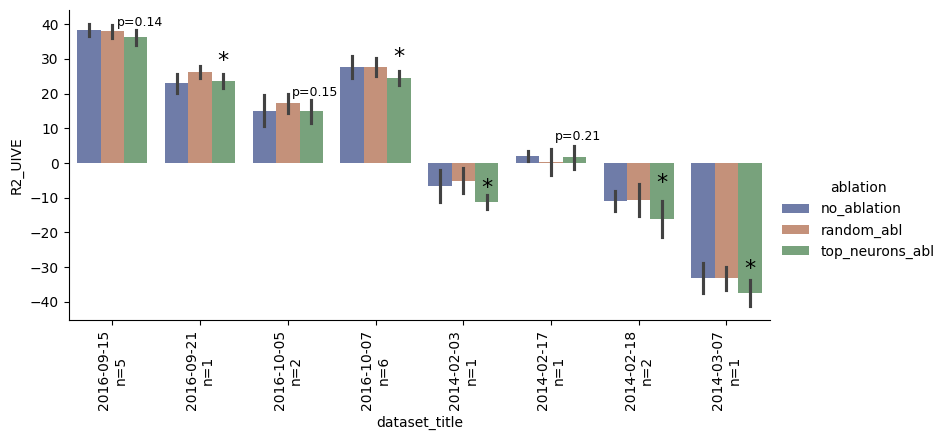

In [11]:
# for each dataset, plot barplots of R2 and check statistical significance between ablations and no ablation
import seaborn as sns
from scipy.stats import ttest_rel

# melt the dataframe
df_plot = pd.melt(df, id_vars=['dataset','dataset_title'], value_vars=['no_ablation','random_abl','top_neurons_abl'],
                    var_name='ablation', value_name='R2_UIVE')

g = sns.catplot(
    data=df_plot, kind="bar",
    x="dataset_title", y="R2_UIVE", hue="ablation",
    ci="sd", palette="dark", alpha=.6, aspect=2, height=4
)   
plt.xticks(rotation=90)
# plt.ylim([83.5,93.5])

# highlight statistically significant changes
for i,dataset in enumerate(experiments):
    t = ttest_rel(df[df.dataset==dataset].random_abl,df[df.dataset==dataset].top_neurons_abl).pvalue
    if t < 0.05:
        plt.text(i+0.2,np.max(df[df.dataset==dataset].top_neurons_abl)+.2,'*',fontsize=16)
    else:
        plt.text(i+0.05,np.max(df[df.dataset==dataset].top_neurons_abl)+.1,f'p={t:.2f}',fontsize=9)

In [9]:
df_plot

,dataset,ablation,R2
0,Chewie_CO_FF_2016-09-15,no_ablation,0.908997
1,Chewie_CO_FF_2016-09-15,no_ablation,0.910327
2,Chewie_CO_FF_2016-09-15,no_ablation,0.912531
3,Chewie_CO_FF_2016-09-15,no_ablation,0.905638
4,Chewie_CO_FF_2016-09-15,no_ablation,0.913944
...,...,...,...
235,Mihili_CO_FF_2014-03-07,random_abl,0.855815
236,Mihili_CO_FF_2014-03-07,random_abl,0.853458
237,Mihili_CO_FF_2014-03-07,random_abl,0.854544
238,Mihili_CO_FF_2014-03-07,random_abl,0.850822


Text(0.5, 1.0, 'Chewie_CO_FF_2016-10-07')

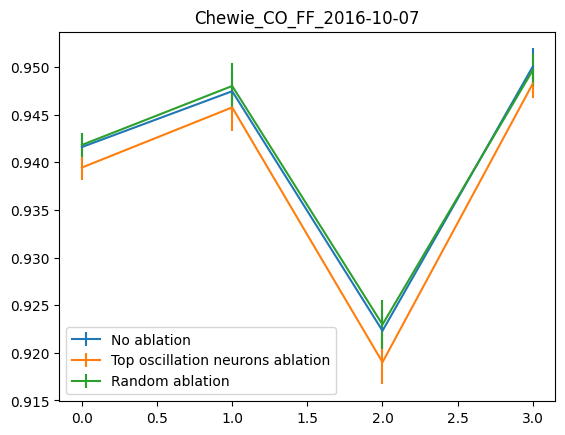

In [8]:
plt.errorbar(range(4),np.mean(no_ablation,axis=0),yerr=np.std(no_ablation,axis=0),label='No ablation')
plt.errorbar(range(4),np.mean(top_score,axis=0),yerr=np.std(top_score,axis=0),label='Top oscillation neurons ablation')
plt.errorbar(range(4),np.mean(r_score,axis=0),yerr=np.std(r_score,axis=0),label='Random ablation')
plt.legend()
plt.title(short_dataset_name)

## Top N

In [68]:
freq = 5
loadpath = f'/disk/scratch2/nkudryas/BAND-torch/results_no_excl_trials/oscillating_score_{short_dataset_name}.npy'
osc_score = np.load(loadpath)

In [69]:
osc_score.shape

(2, 2, 159)

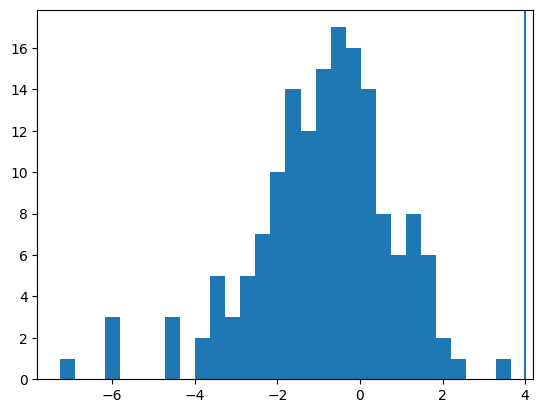

In [70]:
plt.hist(osc_score[0,0],bins=30)
plt.axvline(4)

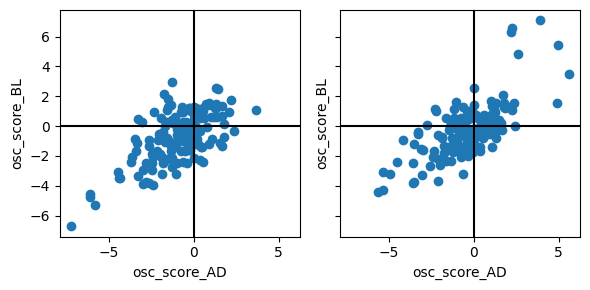

In [72]:
fig, axes = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
for i in [0,1]:
    axes[i].scatter(*osc_score[:,i])
    axes[i].set_xlabel('osc_score_AD')
    axes[i].set_ylabel('osc_score_BL')
    axes[i].axvline(0,c='k')
    axes[i].axhline(0,c='k')
plt.tight_layout()

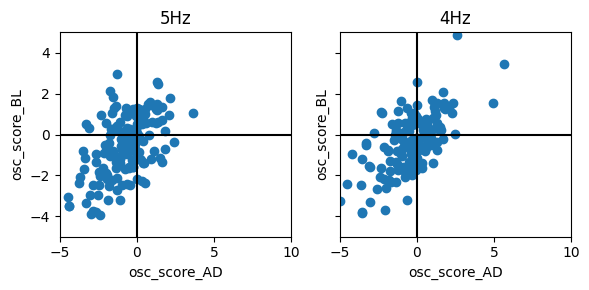

In [73]:
fig, axes = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
for i in [0,1]:
    axes[i].scatter(*osc_score[:,i])
    axes[i].set_xlabel('osc_score_AD')
    axes[i].set_ylabel('osc_score_BL')
    axes[i].axvline(0,c='k')
    axes[i].axhline(0,c='k')
    axes[i].set_xlim(-5,10)
    axes[i].set_ylim(-5,5)
axes[0].set_title('5Hz')
axes[1].set_title('4Hz')
plt.tight_layout()

(array([ 3.,  1.,  1.,  0.,  1.,  1.,  1.,  4., 10., 10., 14., 25., 13.,
        18., 11., 20., 22., 20., 14.,  9.,  7.,  8., 10.,  8.,  5.,  1.,
         2.,  2.,  0.,  2.]),
 array([-4.33708543, -4.04046351, -3.74384159, -3.44721967, -3.15059776,
        -2.85397584, -2.55735392, -2.260732  , -1.96411009, -1.66748817,
        -1.37086625, -1.07424433, -0.77762241, -0.4810005 , -0.18437858,
         0.11224334,  0.40886526,  0.70548717,  1.00210909,  1.29873101,
         1.59535293,  1.89197485,  2.18859676,  2.48521868,  2.7818406 ,
         3.07846252,  3.37508443,  3.67170635,  3.96832827,  4.26495019,
         4.56157211]),
 <BarContainer object of 30 artists>)

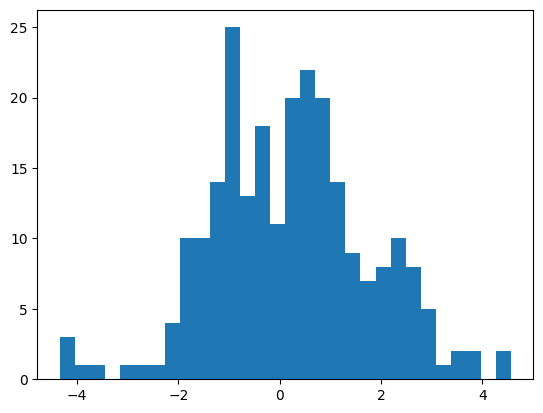

In [38]:
osc_score5 = osc_score[0,0] - osc_score[1,0] # AD - BL
osc_score4 = osc_score[0,1] - osc_score[1,1] # AD - BL
plt.hist(osc_score4,bins=30)
# N_M1 = 81
# osc_score5[N_M1:] = -20

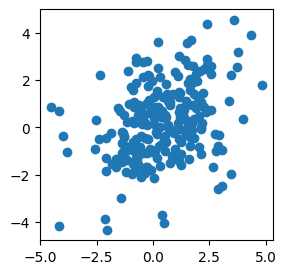

In [39]:
plt.figure(figsize=(3,3))
plt.scatter(osc_score5,osc_score4)

In [40]:
def train_and_get_r2(idxs,
    num_epochs = 1000,
    batch_size = 100):
    '''
    Takes in idxs to ablate
    '''

    train_data = train_data_raw.copy()
    train_data = np.delete(train_data,idxs,axis=-1)
    valid_data = valid_data_raw.copy()
    valid_data = np.delete(valid_data,idxs,axis=-1)

    # train an RNN decoder to predict behavior from neural activity
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
    T = train_data.shape[1] # number of time bins
    assert M == 2, 'only 2D behavior is expected'
    rnn = Decoder(input_size=N, 
                rnn_size=128,
                hidden_size=128, 
                output_size=M, 
                seq_len=T, 
                num_layers=1,
                spike_dropout_rate = 0.2).to(device)


    # Loss and optimizer
    loss = nn.MSELoss()
    # higher weight decay for RNN
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(train_data).to(device)
    behaviors = torch.from_numpy(train_behavior).to(device)
    test_inputs = torch.from_numpy(valid_data).to(device)
    test_behaviors = torch.from_numpy(valid_behavior).to(device)

    # Train the model
    for epoch in range(num_epochs):

        batch_indices = list(range(inputs.shape[0]))
        batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

        # print(batch)

        # Forward pass
        outputs = rnn(inputs[batch])
        cost = loss(outputs, behaviors[batch]) 

        # Backward and optimize
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        scheduler.step(cost)

    # predict on test
    rnn.eval()
    test_outputs = rnn(test_inputs)

    return [r2_score(test_behaviors, test_outputs).item()] +\
           [r2_score(test_behaviors[valid_epoch==e], test_outputs[valid_epoch==e]).item() for e in [0,1,2]]

N_ablate = [0,2,5] + list(range(10, 100, 10)) # + list(range(100,osc_score.shape[0],25))
top_score = []
rand_score = []
for n_ablate in tqdm(N_ablate):

    if n_ablate == 0:
        idxs = []
    else:
        idxs = np.argsort(osc_score4)[-n_ablate:]
    top_score.append(train_and_get_r2(idxs))

    if n_ablate == 0:
        rand_score.append([None])
    else:
        r_score = []
        for _ in range(5):
            idxs = np.random.choice(range(train_data_raw.shape[-1]),n_ablate,replace=False)
            r_score.append(train_and_get_r2(idxs))
        rand_score.append(r_score)
        

            

100%|██████████| 12/12 [12:41<00:00, 63.49s/it]


(11, 5, 4)


Text(0.5, 1.0, 'Mihili_CO_FF_2014-02-17')

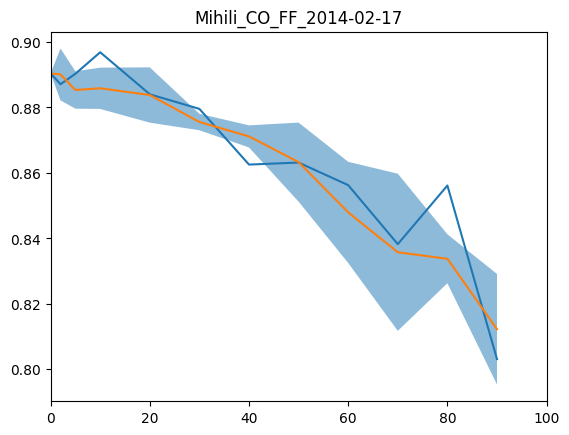

In [19]:
which_r2 = 0
top_score_2plot = np.array(top_score)[:,which_r2]
plt.plot(N_ablate,top_score_2plot,label='top')
print(np.array(rand_score[1:]).shape)
rand_score_2plot = np.concatenate([top_score_2plot[0].reshape((-1,1)).repeat(5,axis=-1),
                                   np.array(rand_score[1:])[...,which_r2]])
plt.plot(N_ablate,np.mean(rand_score_2plot,axis=1),label='rand')
plt.fill_between(N_ablate,np.mean(rand_score_2plot,axis=1)-np.std(rand_score_2plot,axis=1),
                 np.mean(rand_score_2plot,axis=1)+np.std(rand_score_2plot,axis=1),alpha=0.5)

# plt.ylim([0.9,.95])
plt.xlim([0,100])
plt.title(short_dataset_name)

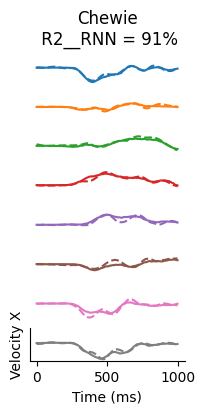

In [61]:
def plot_beh_pred(vel, pred_vel, dir_index, t2p, axes, area, epoch_name, component=0,title=""):
    '''
    Plot hand velocity and predicted hand velocity for each direction
    '''

    BIN_SIZE = 10 # ms
    time = np.arange(vel.shape[1]) * BIN_SIZE

    for v, ls in zip([vel, pred_vel], ["--", "solid"]):
        for t in range(0, vel.shape[0]):
            if t2p[t]:
                d = dir_index[t]
                axes[d].plot(
                    time,
                    v[t, :, component],
                    color=f"C{d}",
                    alpha=1,
                    ls=ls,
                )

    for ax in axes[:-1]:
        ax.axis("off")
    axes[-1].spines['top'].set_visible(False)
    axes[-1].spines['right'].set_visible(False)
    axes[-1].set_yticks([])
    axes[-1].set_xlabel("Time (ms)")
    axes[-1].set_ylabel("Velocity X")

    R2_iso_vel = 1 - np.sum((vel - pred_vel) ** 2) / np.sum((vel - vel.mean(0)) ** 2)
    axes[0].set_title(f'{title}\n R2_{area}_{epoch_name} = {R2_iso_vel*100:.0f}%')

def get_trials2plot(pos, avg_pos, dir_index, epochs,epoch=1):
    '''
    Select the trials to plot based on the distance between 
    the average position and the position in single trials

    Parameters
    ----------
    pos : np.ndarray
        The position in single trials
    avg_pos : np.ndarray
        The average position
    dir_index : np.ndarray
        The direction index
    epochs : np.ndarray
        The epochs
    epoch : int, optional
        The epoch to consider, by default 1 (adaptation)

    Returns
    -------
    np.ndarray
        The trials to plot
    '''
    trials2plot = np.zeros_like(epochs)
    for d in np.unique(dir_index):
        mask = (epochs == epoch) & (dir_index == d)
        # print(mask)
        dist = ((pos - avg_pos) ** 2).sum(-1).sum(-1)
        dist[~mask] = -np.inf
        # print(dist)
        idx_max = np.argmax(dist)
        # print(idx_max)
        trials2plot[idx_max] = 1
    return trials2plot

fig, axes = plt.subplots(8, figsize=(2, 4), sharex=True, sharey=True)
dir_index = np.array([
        sorted(set(valid_target_direction)).index(i) for i in valid_target_direction
    ])

vel = valid_behavior
avg_vel = np.zeros_like(vel)
avg_vel_per_epoch = np.zeros_like(vel)
trial_coverage = np.zeros(vel.shape[0],dtype=bool)
for d in range(8):
    mask = d==dir_index
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==valid_epoch)
        avg_vel_per_epoch[mask] = vel[mask].mean(0)
        trial_coverage[mask] = 1
assert trial_coverage.all()

trials2plot = get_trials2plot(vel, avg_vel_per_epoch, dir_index, valid_epoch, epoch=1)

plot_beh_pred(valid_behavior[valid_epoch == 1], 
              test_outputs.detach().cpu().numpy()[valid_epoch == 1], 
              dir_index[valid_epoch == 1], 
              trials2plot[valid_epoch == 1], 
              axes, '', 'RNN', component=0, title=dataset_name)

In [36]:
# def save_groud_truth(f):
#     f.create_dataset('train_behavior', data=train_behavior)
#     f.create_dataset('valid_behavior', data=valid_behavior)
#     f.create_dataset('train_target_direction', data=train_target_direction)
#     f.create_dataset('valid_target_direction', data=valid_target_direction)
#     f.create_dataset('train_epoch', data=train_epoch)
#     f.create_dataset('valid_epoch', data=valid_epoch)
#     f.create_dataset('train_inds', data=train_inds)
#     f.create_dataset('valid_inds', data=valid_inds)

# def save_results(f):
#     if f'train_{area}_birnn_pred' in f:
#         del f[f'train_{area}_birnn_pred']
#     if f'test_{area}_birnn_pred' in f:
#         del f[f'test_{area}_birnn_pred']
#     f.create_dataset(f'train_{area}_birnn_pred', data=train_outputs.cpu().detach().numpy())
#     f.create_dataset(f'test_{area}_birnn_pred', data=test_outputs.detach().cpu().numpy())
    

# # check if results file is there
# results_path = f'../../results/{short_dataset_name}.h5'
# if not os.path.exists(results_path):
#     with h5py.File(results_path, 'w') as f:
#         save_groud_truth(f)
#         # save results
#         save_results(f)
# else:
#     with h5py.File(results_path, 'a') as f:
#         save_results(f)

# All in a loop

In [10]:
dataset_name = 'Chewie'
num_epochs = 1000
batch_size = 100

experiments = [
    "Chewie_CO_FF_2016-09-15",
    "Chewie_CO_FF_2016-09-21",
    "Chewie_CO_FF_2016-10-05",
    "Chewie_CO_FF_2016-10-07",
    "Mihili_CO_FF_2014-02-03",  # *
    "Mihili_CO_FF_2014-02-17",  # + (only BL)
    "Mihili_CO_FF_2014-02-18",
    "Mihili_CO_FF_2014-03-07",
]

summary_dict = {}   
for short_dataset_name in tqdm(experiments):

    summary_dict[short_dataset_name] = {}

    # check if results file is there
    results_path = f'../../results/{short_dataset_name}.h5'
    if not os.path.exists(results_path):
        with h5py.File(results_path, 'w') as f:
            save_groud_truth(f)

    for area in ['PMd','M1','all']:

        dataset_name = f'{short_dataset_name}_session_vel_{area}_spikes_go'
        loadpath = f'/disk/scratch2/nkudryas/BAND-torch/datasets/{dataset_name}.h5'

        h5file = h5py.File(loadpath, 'r')

        train_data=h5file['train_recon_data'][()].astype(np.float32)
        valid_data=h5file['valid_recon_data'][()].astype(np.float32)
        train_behavior=h5file['train_behavior'][()].astype(np.float32)
        valid_behavior=h5file['valid_behavior'][()].astype(np.float32)
        train_epoch=h5file['train_epoch'][()].astype(np.float32)
        valid_epoch=h5file['valid_epoch'][()].astype(np.float32)
        train_inds=h5file['train_inds'][()].astype(np.float32)
        valid_inds=h5file['valid_inds'][()].astype(np.float32)

        train_target_direction=h5file['train_target_direction'][()].astype(np.float32)
        valid_target_direction=h5file['valid_target_direction'][()].astype(np.float32)
        # print(h5file.keys())
        h5file.close()        
            
        # train an RNN decoder to predict behavior from neural activity
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        N, M = train_data.shape[-1], train_behavior.shape[-1] # number of neurons, number of behavior dimensions
        T = train_data.shape[1] # number of time bins
        assert M == 2, 'only 2D behavior is expected'
        rnn = Decoder(input_size=N, 
                    rnn_size=128,
                    hidden_size=128, 
                    output_size=M, 
                    seq_len=T, 
                    num_layers=1).to(device)


        # Loss and optimizer
        loss = nn.MSELoss()
        # higher weight decay for RNN
        optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=.01)

        #scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

        # Convert numpy arrays to torch tensors
        inputs = torch.from_numpy(train_data).to(device)
        behaviors = torch.from_numpy(train_behavior).to(device)
        test_inputs = torch.from_numpy(valid_data).to(device)
        test_behaviors = torch.from_numpy(valid_behavior).to(device)

        # Train the model
        for epoch in range(num_epochs):

            batch_indices = list(range(inputs.shape[0]))
            batch = torch.from_numpy(np.random.choice(batch_indices, batch_size)).to(device)

            # print(batch)

            # Forward pass
            outputs = rnn(inputs[batch])
            cost = loss(outputs, behaviors[batch]) 

            # Backward and optimize
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            scheduler.step(cost)

            # print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {cost.item():.4f}, Test Loss: {test_cost.item():.4f}')
            # print epoch and R2
            if (epoch+1) % 200 == 0:
                # predict on test
                rnn.eval()
                train_outputs = rnn(inputs)
                train_cost = loss(train_outputs, behaviors) 
                test_outputs = rnn(test_inputs)
                test_cost = loss(test_outputs, test_behaviors)
                rnn.train()
                
                print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_cost.item():.4f}, Test Loss: {test_cost.item():.4f}, R2: {r2_score(test_behaviors, test_outputs).item():.4f}')
                       
        final_r2 = r2_score(test_behaviors, test_outputs).item()
        summary_dict[short_dataset_name][f"{area}_R2_all"] = 100*final_r2 

        for e, epoch_name in enumerate(['BL','AD','WO']):
            final_r2 = r2_score(test_behaviors[valid_epoch==e], test_outputs[valid_epoch==e]).item()
            summary_dict[short_dataset_name][f"{area}_R2_{e}"] = 100*final_r2       

        # save predictions
        with h5py.File(results_path, 'a') as f:
            save_results(f)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [200/1000], Loss: 4.8087, Test Loss: 2.1269, R2: 0.9006
Epoch [400/1000], Loss: 4.4517, Test Loss: 1.9175, R2: 0.9102
Epoch [600/1000], Loss: 4.3918, Test Loss: 1.8998, R2: 0.9111
Epoch [800/1000], Loss: 4.3884, Test Loss: 1.8979, R2: 0.9112
Epoch [1000/1000], Loss: 4.3821, Test Loss: 1.8899, R2: 0.9115
Epoch [200/1000], Loss: 5.1836, Test Loss: 2.2311, R2: 0.8950
Epoch [400/1000], Loss: 4.8493, Test Loss: 2.0302, R2: 0.9045
Epoch [600/1000], Loss: 4.7447, Test Loss: 1.9445, R2: 0.9088
Epoch [800/1000], Loss: 4.7259, Test Loss: 1.9275, R2: 0.9095
Epoch [1000/1000], Loss: 4.7265, Test Loss: 1.9303, R2: 0.9094
Epoch [200/1000], Loss: 4.2807, Test Loss: 1.5784, R2: 0.9262
Epoch [400/1000], Loss: 3.9918, Test Loss: 1.5063, R2: 0.9296
Epoch [600/1000], Loss: 3.8847, Test Loss: 1.4991, R2: 0.9298
Epoch [800/1000], Loss: 3.8624, Test Loss: 1.4864, R2: 0.9304


 12%|█▎        | 1/8 [00:33<03:54, 33.54s/it]

Epoch [1000/1000], Loss: 3.8595, Test Loss: 1.4833, R2: 0.9306
Epoch [200/1000], Loss: 5.4435, Test Loss: 2.2755, R2: 0.8875
Epoch [400/1000], Loss: 5.1205, Test Loss: 2.0704, R2: 0.8976
Epoch [600/1000], Loss: 5.0255, Test Loss: 2.0044, R2: 0.9009
Epoch [800/1000], Loss: 5.0088, Test Loss: 1.9843, R2: 0.9018
Epoch [1000/1000], Loss: 5.0054, Test Loss: 1.9833, R2: 0.9019
Epoch [200/1000], Loss: 5.7029, Test Loss: 2.2247, R2: 0.8898
Epoch [400/1000], Loss: 5.4722, Test Loss: 2.0310, R2: 0.8994
Epoch [600/1000], Loss: 5.3868, Test Loss: 1.9626, R2: 0.9028
Epoch [800/1000], Loss: 5.3841, Test Loss: 1.9578, R2: 0.9030
Epoch [1000/1000], Loss: 5.3802, Test Loss: 1.9559, R2: 0.9031
Epoch [200/1000], Loss: 5.0080, Test Loss: 1.8089, R2: 0.9105
Epoch [400/1000], Loss: 4.5876, Test Loss: 1.5558, R2: 0.9231
Epoch [600/1000], Loss: 4.3758, Test Loss: 1.5552, R2: 0.9231
Epoch [800/1000], Loss: 4.3320, Test Loss: 1.5762, R2: 0.9221


 25%|██▌       | 2/8 [01:06<03:20, 33.38s/it]

Epoch [1000/1000], Loss: 4.3125, Test Loss: 1.5776, R2: 0.9220
Epoch [200/1000], Loss: 6.6685, Test Loss: 8.3279, R2: 0.8852
Epoch [400/1000], Loss: 5.1201, Test Loss: 6.7749, R2: 0.9066
Epoch [600/1000], Loss: 4.9917, Test Loss: 6.7573, R2: 0.9068
Epoch [800/1000], Loss: 4.9112, Test Loss: 6.7170, R2: 0.9074
Epoch [1000/1000], Loss: 4.8990, Test Loss: 6.6935, R2: 0.9077
Epoch [200/1000], Loss: 5.2442, Test Loss: 5.9329, R2: 0.9182
Epoch [400/1000], Loss: 4.2295, Test Loss: 5.1108, R2: 0.9295
Epoch [600/1000], Loss: 3.9235, Test Loss: 4.8199, R2: 0.9335
Epoch [800/1000], Loss: 3.8868, Test Loss: 4.7879, R2: 0.9340
Epoch [1000/1000], Loss: 3.8841, Test Loss: 4.7849, R2: 0.9340
Epoch [200/1000], Loss: 3.8077, Test Loss: 5.1076, R2: 0.9296
Epoch [400/1000], Loss: 2.3369, Test Loss: 3.9113, R2: 0.9461
Epoch [600/1000], Loss: 2.0507, Test Loss: 3.7131, R2: 0.9488
Epoch [800/1000], Loss: 1.9909, Test Loss: 3.6750, R2: 0.9493


 38%|███▊      | 3/8 [01:39<02:45, 33.03s/it]

Epoch [1000/1000], Loss: 1.9779, Test Loss: 3.6701, R2: 0.9494
Epoch [200/1000], Loss: 5.5174, Test Loss: 8.0163, R2: 0.8823
Epoch [400/1000], Loss: 4.4320, Test Loss: 7.2383, R2: 0.8937
Epoch [600/1000], Loss: 4.1933, Test Loss: 7.0359, R2: 0.8966
Epoch [800/1000], Loss: 4.1746, Test Loss: 7.0288, R2: 0.8968
Epoch [1000/1000], Loss: 4.1772, Test Loss: 7.0460, R2: 0.8965
Epoch [200/1000], Loss: 4.9069, Test Loss: 6.1109, R2: 0.9092
Epoch [400/1000], Loss: 3.6077, Test Loss: 4.9975, R2: 0.9260
Epoch [600/1000], Loss: 3.3683, Test Loss: 4.7549, R2: 0.9299
Epoch [800/1000], Loss: 3.2868, Test Loss: 4.7254, R2: 0.9302
Epoch [1000/1000], Loss: 3.2849, Test Loss: 4.7710, R2: 0.9294
Epoch [200/1000], Loss: 3.3892, Test Loss: 5.0115, R2: 0.9260
Epoch [400/1000], Loss: 2.2552, Test Loss: 4.1220, R2: 0.9388
Epoch [600/1000], Loss: 2.0637, Test Loss: 3.9855, R2: 0.9409
Epoch [800/1000], Loss: 2.0092, Test Loss: 3.9541, R2: 0.9414


 50%|█████     | 4/8 [02:12<02:12, 33.05s/it]

Epoch [1000/1000], Loss: 2.0033, Test Loss: 3.9518, R2: 0.9414
Epoch [200/1000], Loss: 13.0468, Test Loss: 15.4244, R2: 0.7287
Epoch [400/1000], Loss: 11.9700, Test Loss: 14.9563, R2: 0.7369
Epoch [600/1000], Loss: 11.7110, Test Loss: 14.9421, R2: 0.7371
Epoch [800/1000], Loss: 11.6208, Test Loss: 14.8509, R2: 0.7387
Epoch [1000/1000], Loss: 11.6041, Test Loss: 14.8726, R2: 0.7384
Epoch [200/1000], Loss: 11.0186, Test Loss: 12.0211, R2: 0.7880
Epoch [400/1000], Loss: 9.7048, Test Loss: 10.7409, R2: 0.8106
Epoch [600/1000], Loss: 9.3361, Test Loss: 10.3999, R2: 0.8165
Epoch [800/1000], Loss: 9.2951, Test Loss: 10.4203, R2: 0.8161
Epoch [1000/1000], Loss: 9.2975, Test Loss: 10.4466, R2: 0.8157
Epoch [200/1000], Loss: 7.9516, Test Loss: 9.1029, R2: 0.8398
Epoch [400/1000], Loss: 6.7081, Test Loss: 8.3152, R2: 0.8538
Epoch [600/1000], Loss: 6.5112, Test Loss: 8.1275, R2: 0.8571
Epoch [800/1000], Loss: 6.4592, Test Loss: 8.0285, R2: 0.8588


 62%|██████▎   | 5/8 [02:45<01:38, 32.96s/it]

Epoch [1000/1000], Loss: 6.4478, Test Loss: 8.0248, R2: 0.8589
Epoch [200/1000], Loss: 11.3647, Test Loss: 13.9246, R2: 0.8152
Epoch [400/1000], Loss: 8.6737, Test Loss: 11.4995, R2: 0.8473
Epoch [600/1000], Loss: 8.3315, Test Loss: 11.1332, R2: 0.8522
Epoch [800/1000], Loss: 8.2926, Test Loss: 11.0716, R2: 0.8530
Epoch [1000/1000], Loss: 8.2842, Test Loss: 11.0695, R2: 0.8531
Epoch [200/1000], Loss: 11.2333, Test Loss: 13.3059, R2: 0.8237
Epoch [400/1000], Loss: 9.8443, Test Loss: 11.4830, R2: 0.8477
Epoch [600/1000], Loss: 9.5530, Test Loss: 11.1141, R2: 0.8526
Epoch [800/1000], Loss: 9.5107, Test Loss: 11.0772, R2: 0.8530
Epoch [1000/1000], Loss: 9.4980, Test Loss: 11.0800, R2: 0.8530
Epoch [200/1000], Loss: 6.5413, Test Loss: 8.7341, R2: 0.8840
Epoch [400/1000], Loss: 4.8681, Test Loss: 7.0895, R2: 0.9061
Epoch [600/1000], Loss: 4.6611, Test Loss: 6.9208, R2: 0.9083
Epoch [800/1000], Loss: 4.6195, Test Loss: 6.8795, R2: 0.9088


 75%|███████▌  | 6/8 [03:17<01:05, 32.69s/it]

Epoch [1000/1000], Loss: 4.6089, Test Loss: 6.8693, R2: 0.9089
Epoch [200/1000], Loss: 8.0795, Test Loss: 9.7209, R2: 0.8595
Epoch [400/1000], Loss: 6.7574, Test Loss: 8.7405, R2: 0.8740
Epoch [600/1000], Loss: 6.4803, Test Loss: 8.4656, R2: 0.8780
Epoch [800/1000], Loss: 6.3938, Test Loss: 8.4325, R2: 0.8784
Epoch [1000/1000], Loss: 6.3859, Test Loss: 8.4145, R2: 0.8787
Epoch [200/1000], Loss: 9.8620, Test Loss: 10.9652, R2: 0.8417
Epoch [400/1000], Loss: 8.0979, Test Loss: 9.2250, R2: 0.8668
Epoch [600/1000], Loss: 7.8625, Test Loss: 9.2667, R2: 0.8662
Epoch [800/1000], Loss: 7.7498, Test Loss: 9.1149, R2: 0.8685
Epoch [1000/1000], Loss: 7.7429, Test Loss: 9.0994, R2: 0.8687
Epoch [200/1000], Loss: 6.4014, Test Loss: 8.2611, R2: 0.8816
Epoch [400/1000], Loss: 4.9236, Test Loss: 6.5913, R2: 0.9053
Epoch [600/1000], Loss: 4.6975, Test Loss: 6.4000, R2: 0.9082
Epoch [800/1000], Loss: 4.6637, Test Loss: 6.3729, R2: 0.9085


 88%|████████▊ | 7/8 [03:49<00:32, 32.56s/it]

Epoch [1000/1000], Loss: 4.6580, Test Loss: 6.3626, R2: 0.9087
Epoch [200/1000], Loss: 11.4481, Test Loss: 14.1591, R2: 0.7959
Epoch [400/1000], Loss: 9.5572, Test Loss: 12.4654, R2: 0.8201
Epoch [600/1000], Loss: 9.3085, Test Loss: 12.4131, R2: 0.8209
Epoch [800/1000], Loss: 9.2530, Test Loss: 12.3007, R2: 0.8225
Epoch [1000/1000], Loss: 9.2513, Test Loss: 12.3199, R2: 0.8223
Epoch [200/1000], Loss: 12.3687, Test Loss: 13.6900, R2: 0.8034
Epoch [400/1000], Loss: 9.8248, Test Loss: 12.3443, R2: 0.8227
Epoch [600/1000], Loss: 9.5507, Test Loss: 12.1273, R2: 0.8259
Epoch [800/1000], Loss: 9.4964, Test Loss: 12.1274, R2: 0.8259
Epoch [1000/1000], Loss: 9.4928, Test Loss: 12.1284, R2: 0.8259
Epoch [200/1000], Loss: 7.3938, Test Loss: 9.5404, R2: 0.8625
Epoch [400/1000], Loss: 5.1804, Test Loss: 8.1874, R2: 0.8820
Epoch [600/1000], Loss: 4.8212, Test Loss: 7.9673, R2: 0.8851
Epoch [800/1000], Loss: 4.7523, Test Loss: 7.9573, R2: 0.8853


100%|██████████| 8/8 [04:21<00:00, 32.71s/it]

Epoch [1000/1000], Loss: 4.7407, Test Loss: 7.9705, R2: 0.8851


FileNotFoundError: [Errno 2] No such file or directory: './results/biRNN_decoder_R2.csv'

In [11]:
# save summary
with open("../../results/biRNN_decoder_R2.csv", "w") as f:
    get_column_names = summary_dict[experiments[0]].keys()
    f.write("Dataset,")
    for key in get_column_names:
        f.write(f"{key},\t")
    f.write('\n')
    for key in summary_dict.keys():
        f.write(f"{key},\t")
        for key2 in get_column_names:
            f.write(f"{summary_dict[key][key2]},\t")
        f.write('\n')